In [1]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import AudioDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization, Conv1D, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from src.helper_functions import plot_reconstruction
import seaborn as sns


In [2]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=32,
    sample_size=128000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_channel_index=0,
    output_size=(128,128))


Found 125440 files for Training set
Found 2560 files for Test set


In [3]:
img_width = 128
img_height = 128
kernel_size = 5
strides = 2

In [4]:
class Time_Freq_Autoencoder_Builder:
    
    def build(width, height, depth, filters=(32,64,128,256), latent_dim=256, kernel_size=5):
        
        strides = 2
        
        input_shape = (height, width, depth)
        inputs = Input(shape = input_shape)
        
        chan_dim = -1
        
        x_time = Reshape(target_shape=(height,width))(inputs)
        x_freq = Reshape(target_shape=(height,width))(tf.transpose(inputs, perm=[0,2,1,3]))
        
        for f in filters:
            
            x_time = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_time)
            x_time = BatchNormalization(axis=chan_dim)(x_time)
            
        x_time = Flatten()(x_time)
        latent_time = Dense(latent_dim//2)(x_time)
        
        for f in filters:
            
            x_freq = Conv1D(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x_freq)
            x_freq = BatchNormalization(axis=chan_dim)(x_freq)
            
        x_freq = Flatten()(x_freq)
        latent_freq = Dense(latent_dim//2)(x_freq)
        
        
        latent_concat = tf.keras.layers.Concatenate(axis=1)([latent_time, latent_freq])
        
        encoder = Model(inputs, latent_concat, name='encoder')
        
        latent_inputs = Input(shape=((latent_dim//2)*2))
        
        x = Dense(16384, activation='relu')(latent_inputs)
        x = Reshape(target_shape=(8,8,256))(x)
        
        for f in filters[::-1]:
            
            x = Conv2DTranspose(f, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
            x = BatchNormalization(axis=chan_dim)(x)
            
        x = Conv2DTranspose(depth, kernel_size=kernel_size, padding='same', activation='sigmoid')(x)
        
        outputs = x
        
        decoder = Model(latent_inputs, outputs, name='decoder')
        
        autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
        
        return (encoder, decoder, autoencoder)
    

class Time_Freq_Autoencoder(tf.keras.Model):
    
    def __init__(self, image_width, image_height, image_depth=1, latent_dim=256, kernel_size=5):
        super().__init__()
        
        self.encoder, self.decoder, self.autoencoder = Time_Freq_Autoencoder_Builder.build(width=image_width, height=image_height, depth=image_depth, latent_dim=256, kernel_size=kernel_size)
        
    def call(self, x):
        autoencoded = self.autoencoder(x)
        return autoencoded
    
autoencoder = Time_Freq_Autoencoder(image_width=img_width, image_height=img_height, latent_dim=256, kernel_size=5)

In [5]:
opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [6]:
autoencoder.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.compat.v1.transpose (TFOpLa  (None, 128, 128, 1)  0          ['input_1[0][0]']                
 mbda)                                                                                            
                                                                                                  
 reshape (Reshape)              (None, 128, 128)     0           ['input_1[0][0]']                
                                                                                            

In [7]:
hist_2 = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=10,
                       validation_data=data_gen.test)

Epoch 1/10


2022-08-18 19:23:54.658736: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3920/3920 [==============================] - 2332s 595ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 2/10
3920/3920 [==============================] - 2326s 593ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 3/10
3920/3920 [==============================] - 2331s 595ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 4/10
3920/3920 [==============================] - 2353s 600ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 5/10
3920/3920 [==============================] - 2343s 598ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 6/10
3920/3920 [==============================] - 2414s 616ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 7/10
3920/3920 [==============================] - 2325s 593ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 8/10
3920/3920 [==============================] - 2326s 593ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 9/10
3920/3920 [==============================] - 2327s 594ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 10/10
3920/3920 [=========================

In [8]:
autoencoder_path = 'data/autoencoder_256dim_time_freq_128k_10epochs'
autoencoder.save(autoencoder_path)

INFO:tensorflow:Assets written to: data/autoencoder_256dim_time_freq_128k_10epochs/assets


INFO:tensorflow:Assets written to: data/autoencoder_256dim_time_freq_128k_10epochs/assets


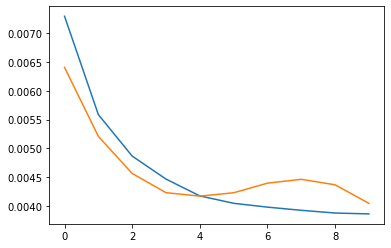

In [9]:
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']
plt.plot(range(len(loss)), loss)
plt.plot(range(len(val_loss)), val_loss)

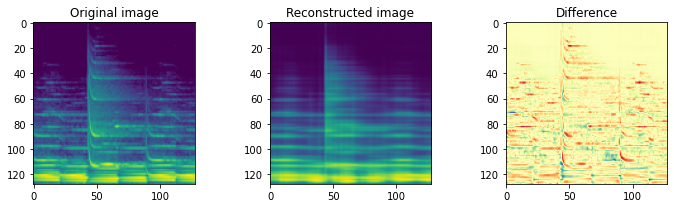

In [10]:
test_img = data_gen.take(1)[0]
prediction = autoencoder(test_img)

plot_reconstruction(test_img, prediction, 1)

In [11]:
from src.LatentSpace import LatentSpace

latent_space = LatentSpace(autoencoder_path=autoencoder_path,
                        image_dir='data/Spotify/comp_pngs/',
                        tracks_feather_path='data/all_tracks.feather', latent_dims=256, output_size=(128, 128)
                        )

Found 278326 files for Generator set


In [12]:
latent_space.build()
latent_space.save(autoencoder_path)

Getting predictions from autoencoder...
[============================================================>] 8697 / 8697

15.29 minutes elapsed
Building tracks dataframe...
size of results 1113216
Track dataframe built. 51.15 minutes elapsed
Building artist distributions...
Artist distributions built. 0.01 minutes elapsed
Building genre distributions...
Genre distributions built. 2.95 minutes elapsed
Latent Space Built.


In [13]:
latent_space.tracks

,id,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,...,track_id,track_name,track_preview_link,track_popularity,track_uri,artist_name,artist_id,artist_genres,artist_popularity,release_date
0,000DpcdeRxaoJKaLgpYXws,1.050180,0.749589,0.208575,-0.071366,-0.944133,1.567048,-0.360349,-0.528596,-0.685536,...,000DpcdeRxaoJKaLgpYXws,Kärlek,https://p.scdn.co/mp3-preview/2c2517c3be174d43...,2,spotify:track:000DpcdeRxaoJKaLgpYXws,Nina Söderquist,4G6CNhvsf2XGfQsf7nioAv,"[europop, swedish melodic rock]",21,2016
1,000OMqK65Cse2zeUoomUfy,0.693398,0.357224,-1.656851,0.954957,0.581771,-0.090570,1.379466,0.058018,-0.314799,...,000OMqK65Cse2zeUoomUfy,Mi Yo Cabrón,https://p.scdn.co/mp3-preview/192c04d469c490bf...,47,spotify:track:000OMqK65Cse2zeUoomUfy,TéCanela,7DqUxnbDJwdpFRS8rIgVy0,[flamenco fusion],43,2017-12-15
2,000P80tkjRpk5aWNmyChqW,0.794105,1.330863,-1.322073,-0.857302,1.053313,-0.122172,0.589969,-2.511123,-0.640349,...,000P80tkjRpk5aWNmyChqW,Broccoli Fuck - KIMMERCORE‘S RIMMERCORE PIEP F...,https://p.scdn.co/mp3-preview/6ad56b9e7b50d67b...,46,spotify:track:000P80tkjRpk5aWNmyChqW,Riot Shift,5J3RIw3YwgyXeosItjR9GY,"[rawstyle, uptempo hardcore, xtra raw]",44,2022-01-31
3,000QWvZpHrBIVrW4dGbaVI,-0.863168,-0.184318,1.790701,0.298788,0.310178,-0.334899,1.132985,0.087955,0.543622,...,000QWvZpHrBIVrW4dGbaVI,General Error,https://p.scdn.co/mp3-preview/d739509a781f67a2...,29,spotify:track:000QWvZpHrBIVrW4dGbaVI,047,1Yf3fs3eLssRoT9T326j8i,[swedish synth],36,None
4,000WkK6rRXx9fRbrw3L7W8,1.178944,1.372584,-1.649071,0.050463,1.110169,0.037753,-0.987393,-0.721195,-1.148014,...,000WkK6rRXx9fRbrw3L7W8,Hey Alli,https://p.scdn.co/mp3-preview/009da3eb8e55d15a...,17,spotify:track:000WkK6rRXx9fRbrw3L7W8,Runner Runner,2VLqBIUWKxrOVYVflf5pbW,"[alternative pop rock, neon pop punk]",27,2014-09-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278299,7zzMTPHYh2ntj2PLQyvrng,0.420585,0.231988,0.823142,2.189218,1.394582,0.344595,0.673006,0.823083,-0.547708,...,7zzMTPHYh2ntj2PLQyvrng,夜明けと蛍,https://p.scdn.co/mp3-preview/f9e23c5bb9255042...,47,spotify:track:7zzMTPHYh2ntj2PLQyvrng,n-buna,5DvySD4yjxyj8NvBWNfImP,[vocaloid],45,None
278300,7zzbfi8fvHe6hm342GcNYl,0.149601,0.215196,-1.420726,0.691364,1.222708,-2.092192,-0.513163,-2.217788,0.182183,...,7zzbfi8fvHe6hm342GcNYl,Black-Throated Wind,https://p.scdn.co/mp3-preview/93ee803354a8fc01...,35,spotify:track:7zzbfi8fvHe6hm342GcNYl,Bob Weir,6YB0tbDGk01Q0P6wcHPjpC,"[blues rock, country rock, jam band, roots rock]",40,None
278301,7zzd7q2VoU8Dkgori4rgCc,0.543530,-0.158907,-0.687219,1.064513,-0.620358,-0.615362,0.316940,1.309268,-0.352080,...,7zzd7q2VoU8Dkgori4rgCc,Dia Bom,https://p.scdn.co/mp3-preview/fff31c24d18bcb78...,35,spotify:track:7zzd7q2VoU8Dkgori4rgCc,Tassia Reis,0kc1BjcLHaXhZVzCp0HeAl,"[afrofuturismo brasileiro, brazilian hip hop, ...",42,2021-07-01
278302,7zzfexN7EknTiRVQEwDRfs,-1.091331,-0.840878,-0.562801,0.983202,0.537400,0.939739,1.069094,-3.052424,0.888515,...,7zzfexN7EknTiRVQEwDRfs,Never Look Back,https://p.scdn.co/mp3-preview/bdfc94eb0d327174...,25,spotify:track:7zzfexN7EknTiRVQEwDRfs,7and5,0PxqaZXFW167XSUiha9eEi,[new age],28,2006


In [63]:
latent_space.tracks[latent_space.tracks.artist_name.str.contains('Vangelis')][['track_id','track_name','artist_name']]

,track_id,track_name,artist_name
27088,0l6TWDKQVA0MIGo15LpzMD,Chronos - Ambrosia Soundtrack Version,Nikos Vangelis
76059,27iy87clL6mJQh9ybqLNK8,Fields of Coral,Vangelis
84170,2LxEIWrZkzfc55c3rk05DH,Tears in Rain,Vangelis
100414,2oDR7QWoLBk9VYMwsFbRGq,Love Theme,Vangelis
130345,3e4VawNTLG2hot2Gvkug8m,Horns,Dimitri Vangelis & Wyman
161892,4Wiub4bQiJTlS224CC19f8,Phantom,Dimitri Vangelis & Wyman
182792,575blCgesVtCu0HEYaIcas,Blade Runner Blues,Vangelis
187450,5FQEeo3o0tPNxrsQPcmwlX,Changes,Dimitri Vangelis & Wyman
199924,5avVpUakfMHD6qGpaH26CF,Conquest of Paradise,Vangelis
217643,65JKNFrK9D0NYjK0I1fiHK,Silence - Interlude,Nikos Vangelis


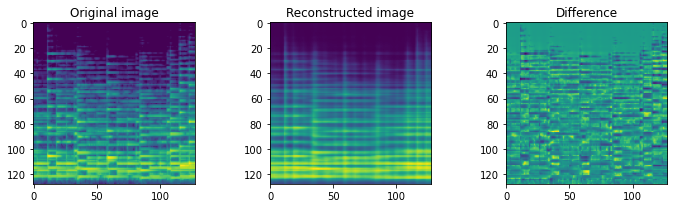

,index,track_name,artist_name,track_uri,similarity
0,316,I’ll Be Loving You,The King Khan & BBQ Show,spotify:track:00XrSeoUJusUuWvqd08lyF,1.000000
1,78413,St Mark,Cutting Pink With Knives,spotify:track:2BoYdeqBYGyYfigOMveg2y,0.398622
2,257226,The Recluse,TV Ghost,spotify:track:7CTh9JGUfQExGlez2aV6D0,0.398225
3,183940,Deep Sleep Rain Storm On Tin Roof Nature's Hyp...,Allyson Kitts,spotify:track:59BKPoDMFI5tbb3O3bJIPm,0.397522
4,161594,Balla Balla,Zeltinger Band,spotify:track:4WD5hRAptpN93IQs30rSrZ,0.396127
5,178305,Taylor Wonderland - Aquagen Remix,Aquagen,spotify:track:4zIB0Y3VYz2wKC3UIyCrJG,0.395032
6,158258,Rain In The Garden,Let It Rain,spotify:track:4QYnie1z5zm6gfFzFfhbye,0.391608
7,121240,Allas vår livvakt,Totalitär,spotify:track:3OLDSyUR3tDHO9ig8EKp1u,0.388976
8,146633,Subvert City,Subhumans,spotify:track:46VraWBV6YA5MTIhHjhrSG,0.386823
9,219174,I'm Pretty Sure I Can See Molecules,Troubled Hubble,spotify:track:682cnlvgwAj2ijHjG30Jaf,0.384924


,artist_name,similarity
0,The King Khan & BBQ Show,0.531390
1,Mark Sultan,0.423867
2,Subhumans,0.413883
3,Electric Eels,0.405139
4,Kome Kome Club,0.391072
5,The Tannahill Weavers,0.390590
6,Kingmaker,0.384004
7,矢島美容室,0.371102
8,Adolescents,0.366819
9,The Meatmen,0.366361


,genre,similarity
0,early us punk,0.373845
1,comic,0.360995
2,pittsburgh indie,0.359290
3,rockabilly,0.337870
4,salsa peruana,0.336721
5,classic persian pop,0.332902
6,alternative pop rock,0.331150
7,rock-and-roll,0.330703
8,salsa international,0.321513
9,brazilian punk,0.319704


In [68]:
seed = 316
latent_space.plot_reconstruction(seed)
display(latent_space.get_similar_tracks_by_index(seed, similarity_measure='cosine'))
display(latent_space.get_similar_artists_by_index(seed))
display(latent_space.get_similar_genres_by_index(seed))

In [56]:
latent_space.results[latent_space.results.id == '6bA4RtHm4n249OETFGpudi'][latent_space.latent_cols]

,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,...,latent_246,latent_247,latent_248,latent_249,latent_250,latent_251,latent_252,latent_253,latent_254,latent_255
174824,84.658081,12.806559,-24.582850,2.402761,-35.549232,4.138393,-0.021275,3.266548,-5.209831,17.630714,...,2.503168,7.799414,3.003933,-19.303747,-3.807637,17.086775,2.266615,5.326147,22.890865,19.290091
174825,84.405655,13.131952,-24.513401,2.940846,-35.768887,5.188595,1.174742,2.756061,-5.592857,18.097401,...,-4.654242,5.495265,-5.393472,-19.398308,-7.398284,-9.898466,4.090092,7.455858,8.486581,8.060923
174826,84.488983,13.086092,-25.094254,3.305816,-35.719021,4.808609,1.420504,2.265106,-5.745080,18.833458,...,-12.778590,0.412446,-6.213917,-10.708762,-10.430250,-31.788330,4.209003,9.282224,-3.909441,-5.496216
174827,85.553032,12.908057,-27.213568,2.998510,-35.986267,4.961448,0.676485,0.170299,-5.377959,19.613930,...,-11.478990,3.112370,1.756408,7.453744,-10.296479,-32.508255,4.698378,4.593742,-6.894569,-17.979841


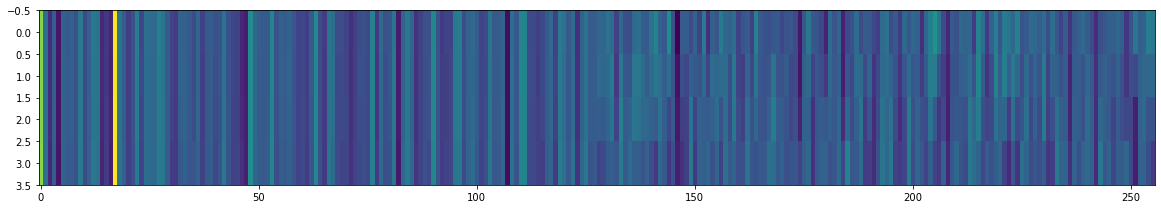

In [58]:
plt.figure(figsize=(20,5))
plt.imshow(latent_space.results[latent_space.results.id == '6bA4RtHm4n249OETFGpudi'][latent_space.latent_cols], aspect=10)

In [49]:
latent_space.get_similar_tracks_by_index(seed)['index']

0    235798
1    185388
2    233609
3    127319
4    251436
5     17827
6    171444
7    277204
8    259179
9    239296
Name: index, dtype: int64